In [1]:
# Import Libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.keras import models, regularizers, callbacks
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, Activation, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [2]:
# -------- CONFIG --------
import kagglehub
# Download the latest version of the dataset
#base = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/version/2/raw-img' # root. its works
path = kagglehub.dataset_download('alessiocorrado99/animals10')
print('path of the dataset:',path)


Using Colab cache for faster access to the 'animals10' dataset.
path of the dataset: /kaggle/input/animals10


In [3]:
# The actual image data is in a subdirectory called 'raw-img'
DATA_DIR = os.path.join(path, 'raw-img') # Set DATA_DIR to the downloaded dataset path plus the subdirectory
print("Data directory:", DATA_DIR)

Data directory: /kaggle/input/animals10/raw-img


In [4]:
# Setting Parameters
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 50
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [5]:
# --- To count image per class and image extension type --------
from collections import Counter

def get_class_counts(data_dir):
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"Data directory not found: {data_dir}")

    # List directories within data_dir as classes
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    counts = {}
    ext_counts = {}
    global_exts = Counter()   # <--- NEW: to track all extensions across dataset

    for c in classes:
        class_path = os.path.join(data_dir, c)
        files = os.listdir(class_path)

        # Count all files in this class
        counts[c] = len(files)

        # Count extensions in this class (case-insensitive)
        exts = [os.path.splitext(f)[1].lower() for f in files if os.path.isfile(os.path.join(class_path, f))]
        ext_counts[c] = dict(Counter(exts))

        # Update global extension counts
        global_exts.update(exts)

    return classes, counts, ext_counts, dict(global_exts)


# usage
classes, counts, ext_counts, global_exts = get_class_counts(DATA_DIR)

print("Counts per class:")
for c in classes:
    print(f"  {c}: {counts[c]} files")
    print(f"     Extensions: {ext_counts[c]}")

print("\nOverall extension counts (all classes combined):")
print(global_exts)


Counts per class:
  cane: 4863 files
     Extensions: {'.jpeg': 4863}
  cavallo: 2623 files
     Extensions: {'.jpeg': 2623}
  elefante: 1446 files
     Extensions: {'.jpeg': 1079, '.jpg': 359, '.png': 8}
  farfalla: 2112 files
     Extensions: {'.jpeg': 1650, '.jpg': 422, '.png': 40}
  gallina: 3098 files
     Extensions: {'.jpeg': 3098}
  gatto: 1668 files
     Extensions: {'.jpeg': 1227, '.jpg': 440, '.png': 1}
  mucca: 1866 files
     Extensions: {'.jpeg': 1866}
  pecora: 1820 files
     Extensions: {'.jpeg': 1444, '.jpg': 376}
  ragno: 4821 files
     Extensions: {'.jpeg': 4497, '.jpg': 322, '.png': 2}
  scoiattolo: 1862 files
     Extensions: {'.jpeg': 1862}

Overall extension counts (all classes combined):
{'.jpeg': 24209, '.jpg': 1919, '.png': 51}


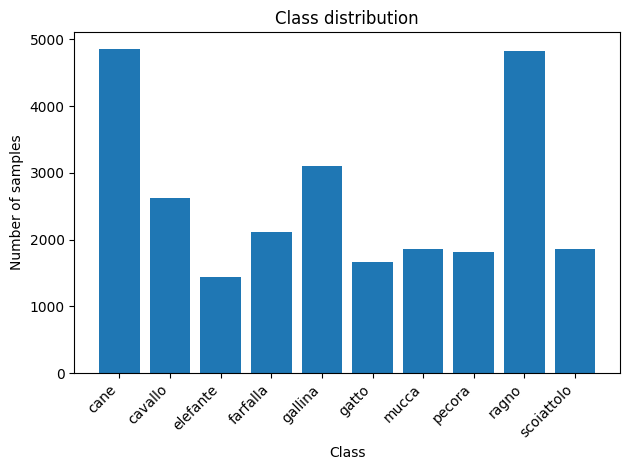

In [6]:
# Visualize
plt.bar(classes, counts.values())
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

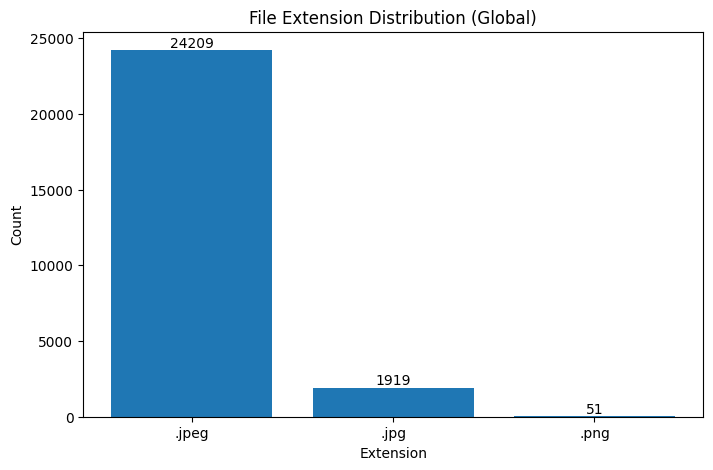

In [7]:
# Visualize
# Sort by frequency for clarity
# Sort by frequency for clarity
sorted_exts = dict(sorted(global_exts.items(), key=lambda x: x[1], reverse=True))

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_exts.keys(), sorted_exts.values())

plt.title("File Extension Distribution (Global)")
plt.xlabel("Extension")
plt.ylabel("Count")

# Add counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: middle of the bar
        height,                             # y position: top of the bar
        str(height),                        # text = count value
        ha='center', va='bottom', fontsize=10
    )

plt.show()


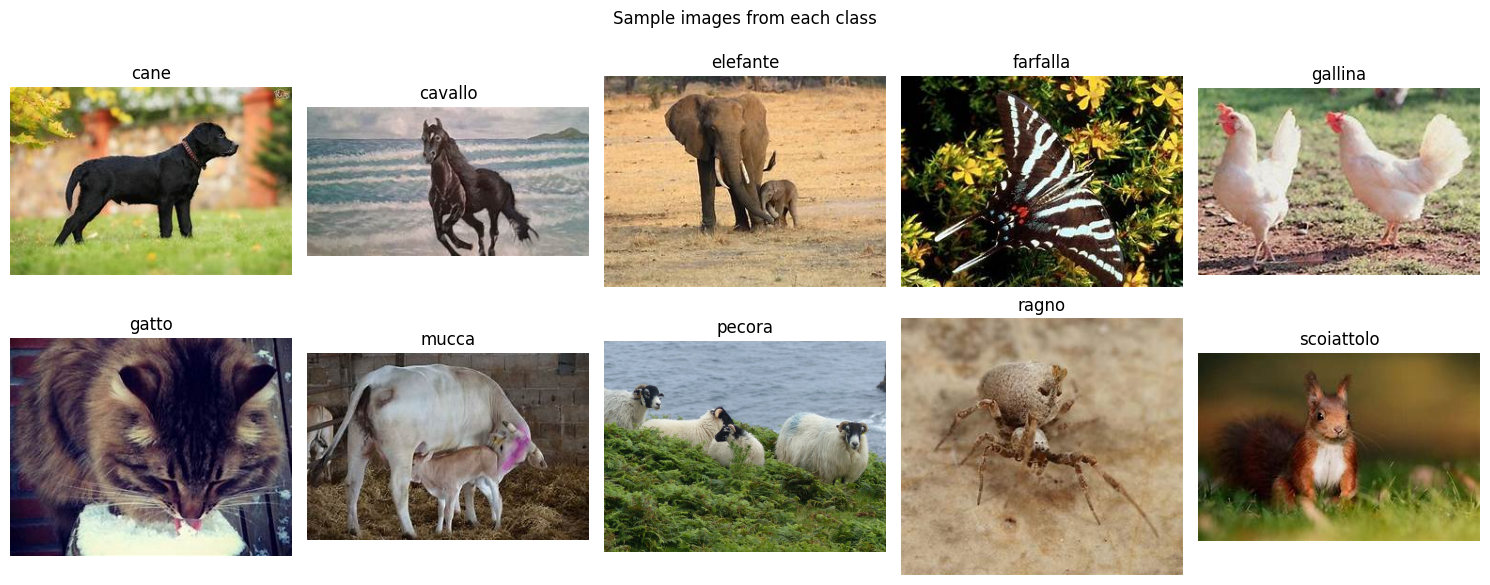

In [8]:
# -------- EDA: sample images and size distribution  --------
def sample_images_grid(data_dir, classes, ncols=5):
    nrows = (len(classes) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    axes = axes.flatten()
    idx = 0
    for c in classes:
        class_folder = os.path.join(data_dir, c)
        imgs = [os.path.join(class_folder, f) for f in os.listdir(class_folder)
                if f.lower().endswith(('.jpg','.png','.jpeg'))]
        if not imgs:
            continue
        img_path = random.choice(imgs)
        img = Image.open(img_path).convert('RGB')
        axes[idx].imshow(np.array(img))
        axes[idx].axis('off')
        axes[idx].set_title(c)
        idx += 1
    for j in range(idx, len(axes)):
        axes[j].axis('off')
    plt.suptitle("Sample images from each class")
    plt.tight_layout()
    plt.show()

sample_images_grid(DATA_DIR, classes)

In [9]:
# ---------- BALANCE VIA UPSAMPLING (flow_from_dataframe) ----------
from sklearn.model_selection import train_test_split

# Build dataframe of all image file paths and class names
all_files = []
all_labels = []
for cls_name in sorted(os.listdir(DATA_DIR)):
    cls_dir = os.path.join(DATA_DIR, cls_name)
    if not os.path.isdir(cls_dir):
        continue
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_files.append(os.path.join(cls_dir, fname))
            all_labels.append(cls_name)

df = pd.DataFrame({'filepath': all_files, 'class': all_labels})
print("Total images:", len(df))
print("Original class counts:\n", df['class'].value_counts().to_dict())



# Split into train / val (stratified) FIRST
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=SEED)
print("Train counts before upsampling:\n", df_train['class'].value_counts().to_dict())
print("Val counts:\n", df_val['class'].value_counts().to_dict())

# Choose target count for upsampling in the training set
TARGET_COUNT = int(df_train['class'].value_counts().max()) # Use max count from the training set
# Upsample each class in the training dataframe to TARGET_COUNT
rows = []
for cls, group in df_train.groupby('class'): # Upsample only the training data
    n = len(group)
    # If group has >= TARGET_COUNT, sample without replacement to TARGET_COUNT
    # If group has < TARGET_COUNT, sample with replacement to TARGET_COUNT
    sampled = group.sample(n=TARGET_COUNT, replace=(n < TARGET_COUNT), random_state=SEED)
    rows.append(sampled)

df_train_bal = pd.concat(rows, ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Train counts after upsampling:\n", df_train_bal['class'].value_counts().to_dict())


Total images: 26179
Original class counts:
 {'cane': 4863, 'ragno': 4821, 'gallina': 3098, 'cavallo': 2623, 'farfalla': 2112, 'mucca': 1866, 'scoiattolo': 1862, 'pecora': 1820, 'gatto': 1668, 'elefante': 1446}
Train counts before upsampling:
 {'cane': 3890, 'ragno': 3857, 'gallina': 2478, 'cavallo': 2098, 'farfalla': 1690, 'mucca': 1493, 'scoiattolo': 1490, 'pecora': 1456, 'gatto': 1334, 'elefante': 1157}
Val counts:
 {'cane': 973, 'ragno': 964, 'gallina': 620, 'cavallo': 525, 'farfalla': 422, 'mucca': 373, 'scoiattolo': 372, 'pecora': 364, 'gatto': 334, 'elefante': 289}
Train counts after upsampling:
 {'cavallo': 3890, 'farfalla': 3890, 'ragno': 3890, 'gallina': 3890, 'pecora': 3890, 'cane': 3890, 'elefante': 3890, 'gatto': 3890, 'scoiattolo': 3890, 'mucca': 3890}


In [10]:
# ----- Image generator and Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepath',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [11]:
# Show augmentation examples (using tf.keras preprocessing)
def show_augmentations(sample_path, datagen, target_size, n=7):
    img = tf.keras.preprocessing.image.load_img(sample_path, target_size=target_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    plt.figure(figsize=(12,4))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(1,n,i+1)
        # batch[0] is the augmented image with rescaling if applied (values between 0-1),
        # convert to uint8 for display
        arr = (batch[0] * 255).astype('uint8')
        plt.imshow(arr)
        plt.axis('off')
        i += 1
        if i >= n:
            break
    plt.suptitle("Augmentation examples")
    plt.show()

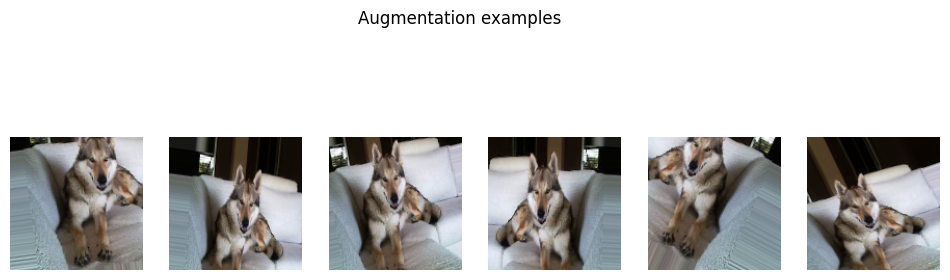

In [ ]:
# pick a sample safely
if classes:
    any_class = classes[0]
    class_files = [f for f in os.listdir(os.path.join(DATA_DIR, any_class))
                   if f.lower().endswith(('.jpg','.png','.jpeg'))]
    if class_files:
        sample_path = os.path.join(DATA_DIR, any_class, class_files[0])
        show_augmentations(sample_path, train_datagen, TARGET_SIZE, n=6)



In [ ]:
# --------- Model Builder Function ---------
from tensorflow.keras.models import Sequential # Added import for Sequential
from tensorflow.keras import regularizers
def build_cnn_model(num_filters = 32, num_hidden = 3, neurons = 64, dropout_rate = 0.1):
    model = Sequential()
    model.add(Conv2D(num_filters, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(num_filters * 2, (3, 3), activation = 'relu'))
    model.add(Conv2D(num_filters * 2, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(num_filters * 2, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    for _ in range(num_hidden):
        model.add(Dense(neurons, activation = 'relu'))
        model.add(Dense(neurons*2, activation = 'relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(len(train_generator.class_indices), activation = 'softmax',kernel_regularizer=regularizers.l2(1e-4)))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

# Call the function to create the model and then print the summary
model = build_cnn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 868,170 (3.31 MB)

 Trainable params: 868,170 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Train multiple models ----
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

configs = [
    {"num_filters" : 64, "num_hidden" : 3, "neurons" : 256, "dropout_rate" : 0.0},
]

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=7, min_lr=1e-6)

results = []
for cfg in configs:
    model = build_cnn_model(**cfg)
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator,callbacks=[reduce_lr,early_stop], verbose = 1)
    val_acc = max(history.history['val_accuracy'])
    results.append((cfg, val_acc))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 132s 195ms/step - accuracy: 0.2263 - loss: 2.1324 - val_accuracy: 0.3825 - val_loss: 1.7661 - learning_rate: 0.0010
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 125s 191ms/step - accuracy: 0.4028 - loss: 1.7200 - val_accuracy: 0.5246 - val_loss: 1.3831 - learning_rate: 0.0010
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 125s 190ms/step - accuracy: 0.4947 - loss: 1.4882 - val_accuracy: 0.5428 - val_loss: 1.3278 - learning_rate: 0.0010
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 125s 191ms/step - accuracy: 0.5331 - loss: 1.3615 - val_accuracy: 0.5636 - val_loss: 1.2737 - learning_rate: 0.0010
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 125s 190ms/step - accuracy: 0.5565 - loss: 1.2806 - val_accuracy: 0.5621 - val_loss: 1.2642 - learning_rate: 0.0010
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 124s 189ms/step - accuracy: 0.5840 - loss: 1.2181 - val_accuracy: 0.6295 - val_loss: 1.1176 - learning_rate: 0.0010
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 124s 190ms/step - accura

In [ ]:
# print best configuration
print('\nFinal Result')
for cfg, acc in results:
    print(f"Config: {cfg}, Validation Accuracy: {acc:3f}")


Final Result
Config: {'num_filters': 64, 'num_hidden': 3, 'neurons': 256, 'dropout_rate': 0.0}, Validation Accuracy: 0.744461


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step


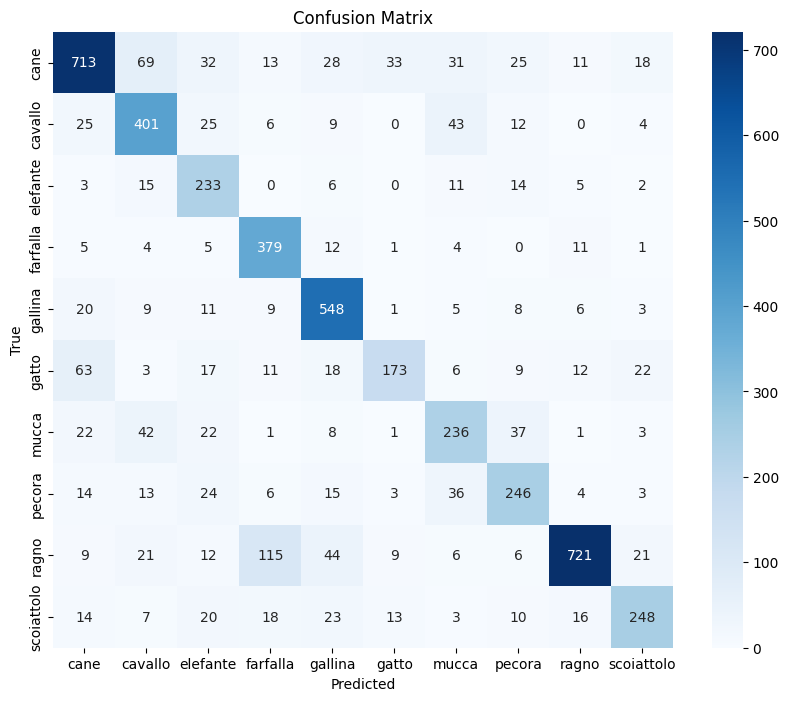

Classification Report:
              precision    recall  f1-score   support

        cane       0.80      0.73      0.77       973
     cavallo       0.69      0.76      0.72       525
    elefante       0.58      0.81      0.68       289
    farfalla       0.68      0.90      0.77       422
     gallina       0.77      0.88      0.82       620
       gatto       0.74      0.52      0.61       334
       mucca       0.62      0.63      0.63       373
      pecora       0.67      0.68      0.67       364
       ragno       0.92      0.75      0.82       964
  scoiattolo       0.76      0.67      0.71       372

    accuracy                           0.74      5236
   macro avg       0.72      0.73      0.72      5236
weighted avg       0.76      0.74      0.74      5236



In [ ]:

# -------- Evaluation: confusion matrix & classification report (PIL-based image display) --------
val_generator.reset()
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

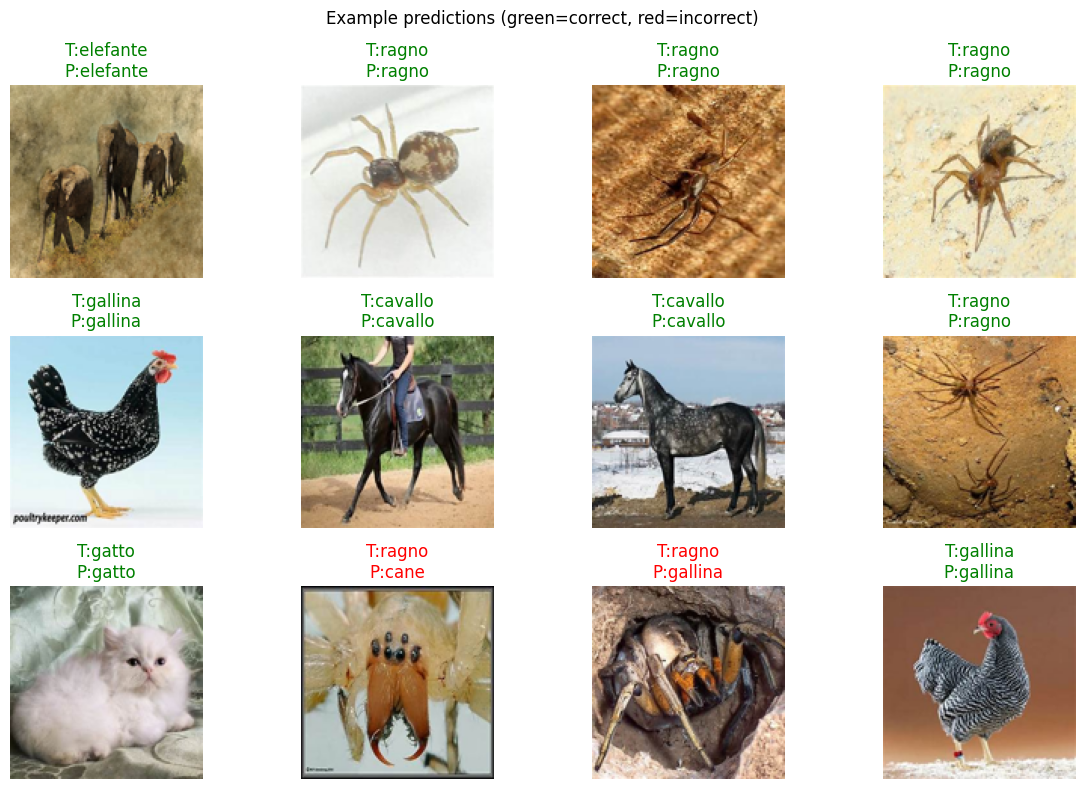

In [ ]:
# Plot some example predictions (true vs predicted) using PIL to load/resize
def show_predictions(generator, y_pred, y_true, labels, n=12):
    plt.figure(figsize=(12,8))
    filenames = generator.filenames
    chosen = np.random.choice(len(filenames), size=min(n, len(filenames)), replace=False)
    for i, idx in enumerate(chosen):
        img_path = os.path.join(DATA_DIR, filenames[idx])
        try:
            img = Image.open(img_path).convert('RGB')
            img_resized = img.resize(TARGET_SIZE)
            arr = np.array(img_resized)
        except Exception as e:
            arr = np.zeros((TARGET_SIZE[1], TARGET_SIZE[0], 3), dtype='uint8')
            print("Failed to open", img_path, e)
        plt.subplot(3, 4, i+1)
        plt.imshow(arr)
        plt.axis('off')
        true_label = labels[y_true[idx]]
        pred_label = labels[y_pred[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"T:{true_label}\nP:{pred_label}", color=color)
    plt.suptitle("Example predictions (green=correct, red=incorrect)")
    plt.tight_layout(); plt.show()

show_predictions(val_generator, y_pred, y_true, labels, n=12)

In [ ]:
# Save history CSV
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("history.csv", index=False)
print("Saved optimized_history.csv and best_model.h5 (if checkpoint saved).")

Saved optimized_history.csv and best_model.h5 (if checkpoint saved).


In [ ]:
# Let's try transfer Learning -EfficientNetV2B0

In [19]:
from tensorflow.keras import layers, regularizers, optimizers, models

# freeze base and use imagenet weights
base_model = tf.keras.applications.EfficientNetV2B0(
    weights='imagenet', include_top=False, input_shape=(128,128,3)
)
base_model.trainable = True

inputs = layers.Input(shape=(128,128,3))
# ensures base BN layers run in inference mode when frozen
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)

# Create the Keras Model
model = models.Model(inputs=inputs, outputs=outputs)

In [20]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=1e-6)

In [22]:
# Fitting the data
history = model.fit(train_generator, epochs = 20, validation_data = val_generator,
                    callbacks = [reduce_lr,early_stop], verbose = 1)

Epoch 1/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 272s 288ms/step - accuracy: 0.3117 - loss: 2.2948 - val_accuracy: 0.6209 - val_loss: 1.2013 - learning_rate: 5.0000e-05
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 138s 210ms/step - accuracy: 0.6349 - loss: 1.1630 - val_accuracy: 0.6896 - val_loss: 0.9930 - learning_rate: 5.0000e-05
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 139s 212ms/step - accuracy: 0.7502 - loss: 0.8173 - val_accuracy: 0.8210 - val_loss: 0.6079 - learning_rate: 5.0000e-05
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 137s 210ms/step - accuracy: 0.7974 - loss: 0.6601 - val_accuracy: 0.8401 - val_loss: 0.5276 - learning_rate: 5.0000e-05
Epoch 5/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 137s 210ms/step - accuracy: 0.8374 - loss: 0.5537 - val_accuracy: 0.8424 - val_loss: 0.5240 - learning_rate: 5.0000e-05
Epoch 6/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 138s 211ms/step - accuracy: 0.8562 - loss: 0.4856 - val_accuracy: 0.9047 - val_loss: 0.3311 - learning_rate: 5.0000e-05
Epoch 7/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 